# Chapter 6 - Linear Model Selection and Regularization

### We are going to predict baseball salaries from performance data.  

In [22]:
# %load ../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error


In [23]:
df = pd.read_csv('data/Hitters.csv', index_col=0)
df.index.name = 'Player'
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 322 entries, -Andy Allanson to -Willie Wilson
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AtBat      322 non-null    int64  
 1   Hits       322 non-null    int64  
 2   HmRun      322 non-null    int64  
 3   Runs       322 non-null    int64  
 4   RBI        322 non-null    int64  
 5   Walks      322 non-null    int64  
 6   Years      322 non-null    int64  
 7   CAtBat     322 non-null    int64  
 8   CHits      322 non-null    int64  
 9   CHmRun     322 non-null    int64  
 10  CRuns      322 non-null    int64  
 11  CRBI       322 non-null    int64  
 12  CWalks     322 non-null    int64  
 13  League     322 non-null    object 
 14  Division   322 non-null    object 
 15  PutOuts    322 non-null    int64  
 16  Assists    322 non-null    int64  
 17  Errors     322 non-null    int64  
 18  Salary     263 non-null    float64
 19  NewLeague  322 non-null    obje

In [24]:
#Lets preemptively get rid of garbage. 
df=df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, -Alan Ashby to -Willie Wilson
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AtBat      263 non-null    int64  
 1   Hits       263 non-null    int64  
 2   HmRun      263 non-null    int64  
 3   Runs       263 non-null    int64  
 4   RBI        263 non-null    int64  
 5   Walks      263 non-null    int64  
 6   Years      263 non-null    int64  
 7   CAtBat     263 non-null    int64  
 8   CHits      263 non-null    int64  
 9   CHmRun     263 non-null    int64  
 10  CRuns      263 non-null    int64  
 11  CRBI       263 non-null    int64  
 12  CWalks     263 non-null    int64  
 13  League     263 non-null    object 
 14  Division   263 non-null    object 
 15  PutOuts    263 non-null    int64  
 16  Assists    263 non-null    int64  
 17  Errors     263 non-null    int64  
 18  Salary     263 non-null    float64
 19  NewLeague  263 non-null    object 

In [25]:
df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
Player,,,,,,,,,,,,,,,,,,,,
-Alan Ashby,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
-Alvin Davis,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
-Andre Dawson,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
-Andres Galarraga,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
-Alfredo Griffin,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A


In [26]:

dummies = pd.get_dummies(df[['League', 'Division', 'NewLeague']])
dummies.info()
print(dummies.head())

<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, -Alan Ashby to -Willie Wilson
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   League_A     263 non-null    uint8
 1   League_N     263 non-null    uint8
 2   Division_E   263 non-null    uint8
 3   Division_W   263 non-null    uint8
 4   NewLeague_A  263 non-null    uint8
 5   NewLeague_N  263 non-null    uint8
dtypes: uint8(6)
memory usage: 3.6+ KB
                   League_A  League_N  Division_E  Division_W  NewLeague_A  \
Player                                                                       
-Alan Ashby               0         1           0           1            0   
-Alvin Davis              1         0           0           1            1   
-Andre Dawson             0         1           1           0            0   
-Andres Galarraga         0         1           1           0            0   
-Alfredo Griffin          1         0           0    

In [27]:
y = df.Salary
# Drop the column with the independent variable (Salary), and columns for which we created dummy variables
X_ = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')
# Define the feature set X appending 
X = pd.concat([X_, dummies[['League_N', 'Division_W']]], axis=1)
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, -Alan Ashby to -Willie Wilson
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   AtBat       263 non-null    float64
 1   Hits        263 non-null    float64
 2   HmRun       263 non-null    float64
 3   Runs        263 non-null    float64
 4   RBI         263 non-null    float64
 5   Walks       263 non-null    float64
 6   Years       263 non-null    float64
 7   CAtBat      263 non-null    float64
 8   CHits       263 non-null    float64
 9   CHmRun      263 non-null    float64
 10  CRuns       263 non-null    float64
 11  CRBI        263 non-null    float64
 12  CWalks      263 non-null    float64
 13  PutOuts     263 non-null    float64
 14  Assists     263 non-null    float64
 15  Errors      263 non-null    float64
 16  League_N    263 non-null    uint8  
 17  Division_W  263 non-null    uint8  
dtypes: float64(16), uint8(2)
memory usage: 35.4+ KB


In [28]:
X.head(5)

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,League_N,Division_W
Player,,,,,,,,,,,,,,,,,,
-Alan Ashby,315.0,81.0,7.0,24.0,38.0,39.0,14.0,3449.0,835.0,69.0,321.0,414.0,375.0,632.0,43.0,10.0,1,1
-Alvin Davis,479.0,130.0,18.0,66.0,72.0,76.0,3.0,1624.0,457.0,63.0,224.0,266.0,263.0,880.0,82.0,14.0,0,1
-Andre Dawson,496.0,141.0,20.0,65.0,78.0,37.0,11.0,5628.0,1575.0,225.0,828.0,838.0,354.0,200.0,11.0,3.0,1,0
-Andres Galarraga,321.0,87.0,10.0,39.0,42.0,30.0,2.0,396.0,101.0,12.0,48.0,46.0,33.0,805.0,40.0,4.0,1,0
-Alfredo Griffin,594.0,169.0,4.0,74.0,51.0,35.0,11.0,4408.0,1133.0,19.0,501.0,336.0,194.0,282.0,421.0,25.0,0,1


## Split the data into training and test sets 

In [29]:
X_train,X_test, y_train,y_test = train_test_split(X,y,test_size = 0.25,random_state = 22,shuffle=True)

## Build a standard scaler model from the training set. 

In [30]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test) # notice that the test data is not being fit

## Multiple Linear Regression 

0.46046709773994876


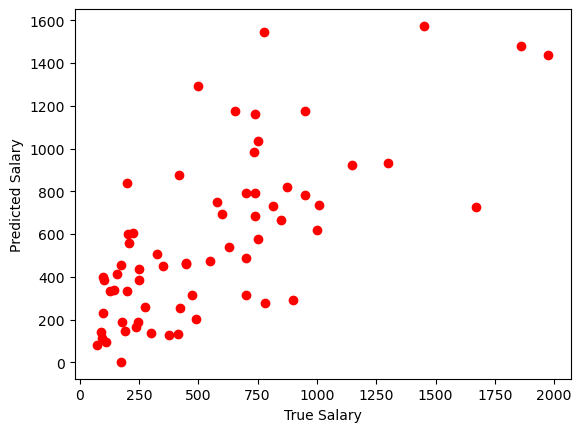

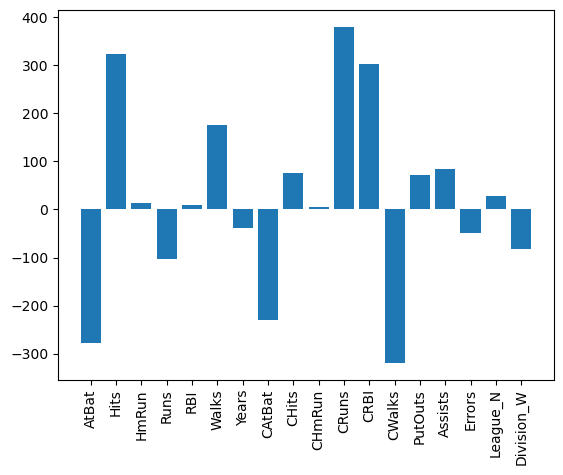

In [41]:
reg = LinearRegression().fit(X_train,y_train)
y_pred = reg.predict(X_test)
score = reg.score(X_test,y_test)
print(score)
plt.figure()
plt.plot(y_test,y_pred,'ro')
plt.xlabel('True Salary')
plt.ylabel('Predicted Salary')
plt.show()
plt.figure()
plt.bar(X.columns,reg.coef_)
plt.xticks(rotation= "vertical")
plt.show()

##The Lasso

In [86]:
lassocv = LassoCV(alphas=None, cv=5, max_iter=10000)
lassocv.fit(X_train, y_train)


LassoCV(cv=5, max_iter=10000)

In [87]:
lassocv.alpha_

5.049507537853908

In [88]:
lasso = Lasso(max_iter = 10000)
lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)
lasso.score(X_train,y_train)

0.5204264881839046

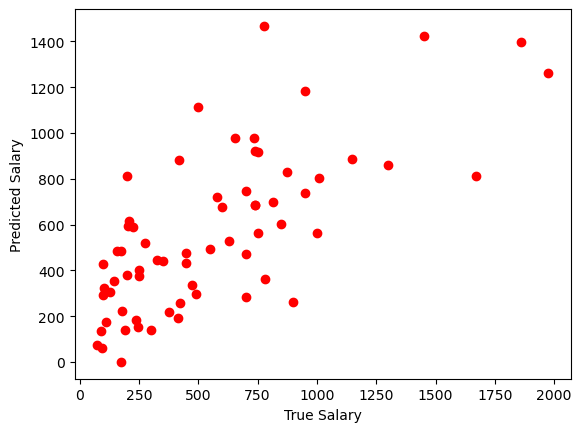

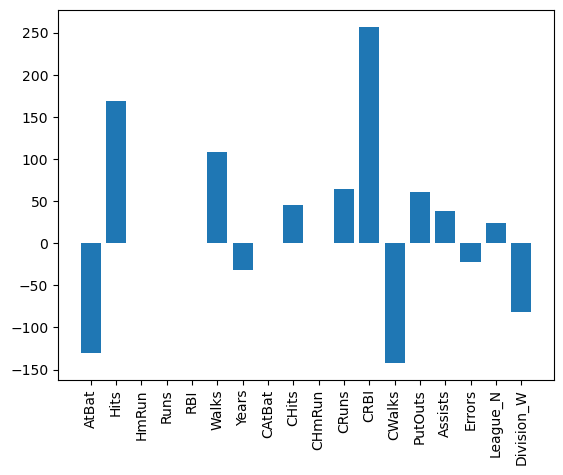

In [89]:
plt.figure()
plt.plot(y_test,y_pred,'ro')
plt.xlabel('True Salary')
plt.ylabel('Predicted Salary')
plt.show()
plt.figure()
plt.bar(X.columns,lasso.coef_)
plt.xticks(rotation= "vertical")
plt.show()